# Breast Cancer Detection Challenge

In [1]:
import numpy as np
import pandas as pd
import shap
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# supress unnecessary warning msgs.
import warnings
warnings.filterwarnings('ignore')

c:\Users\mgumbert\AppData\Local\anaconda3\envs\MLG\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data cleaning and EDA:

In [2]:
df = pd.read_csv('../data/data-breast-cancer.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
# size of data set
df.shape

(569, 33)

In [4]:
# check out the y variable
df.diagnosis.value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

In [5]:
#check number of unique values in each column
df.nunique()

id                         569
diagnosis                    2
radius_mean                456
texture_mean               479
perimeter_mean             522
area_mean                  539
smoothness_mean            474
compactness_mean           537
concavity_mean             537
concave points_mean        542
symmetry_mean              432
fractal_dimension_mean     499
radius_se                  540
texture_se                 519
perimeter_se               533
area_se                    528
smoothness_se              547
compactness_se             541
concavity_se               533
concave points_se          507
symmetry_se                498
fractal_dimension_se       545
radius_worst               457
texture_worst              511
perimeter_worst            514
area_worst                 544
smoothness_worst           411
compactness_worst          529
concavity_worst            539
concave points_worst       492
symmetry_worst             500
fractal_dimension_worst    535
Unnamed:

In [6]:
# check if any NaNs are present
df.isna().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [7]:
# "Unnamed 32" column looks fishy
df['Unnamed: 32'].head(10)

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: Unnamed: 32, dtype: float64

In [8]:
# ...drop it. also drop "id" column as it might introduce bias
df = df.drop(columns=['Unnamed: 32', 'id'])

In [9]:
# cross-check for missing values
df.isnull().sum().sum()

0

In [10]:
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


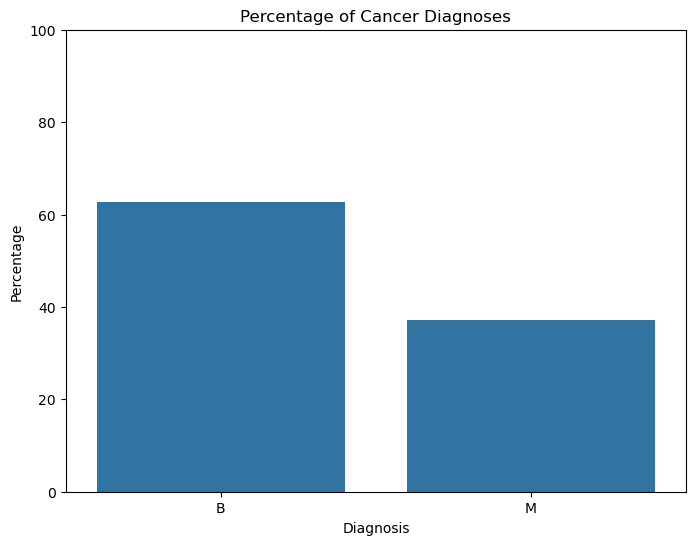

In [11]:
diagnosis_counts = df['diagnosis'].value_counts(normalize=True) * 100

# Convert to DataFrame for plotting
diagnosis_percentages = diagnosis_counts.reset_index()
diagnosis_percentages.columns = ['diagnosis', 'percentage']

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x='diagnosis', y='percentage', data=diagnosis_percentages)

# Set the title and labels
plt.title('Percentage of Cancer Diagnoses')
plt.xlabel('Diagnosis')
plt.ylabel('Percentage')
plt.ylim(0, 100)

# Display the plot
plt.show()

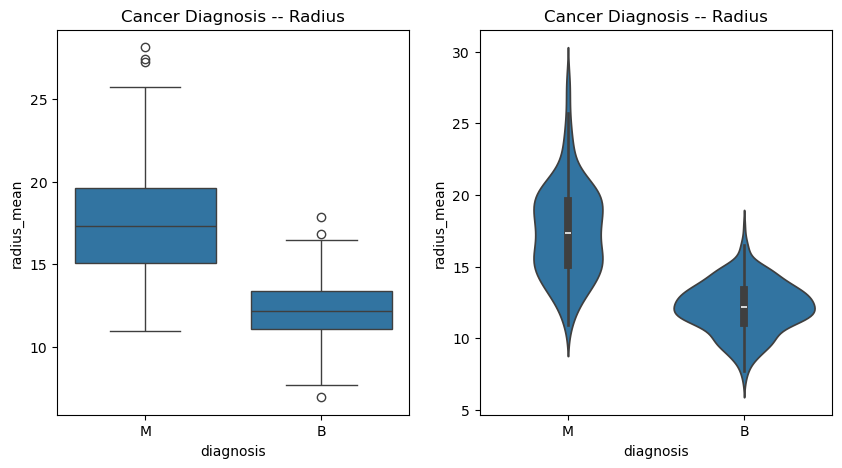

In [12]:
# correlation radius - cancer diagnosis?
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.boxplot(x="diagnosis", y="radius_mean", data=df)
plt.title('Cancer Diagnosis -- Radius')
plt.subplot(1,2,2)
sns.violinplot(x="diagnosis", y="radius_mean", data=df)
plt.title('Cancer Diagnosis -- Radius')
plt.show()

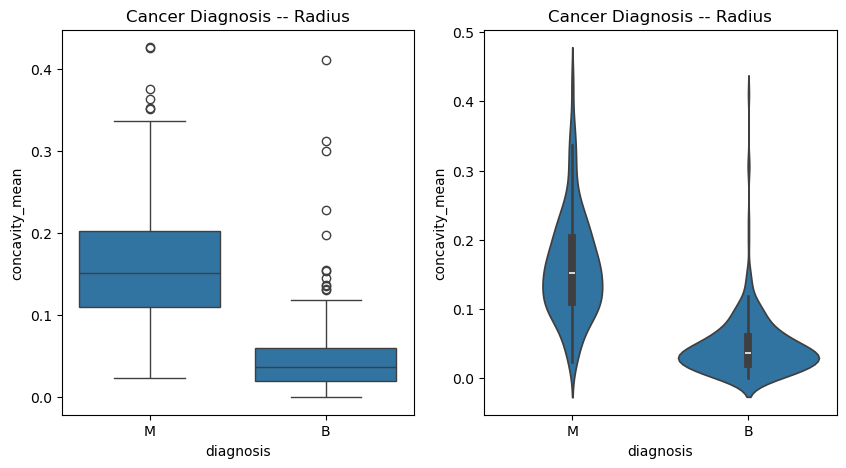

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.boxplot(x="diagnosis", y="concavity_mean", data=df)
plt.title('Cancer Diagnosis -- Radius')
plt.subplot(1,2,2)
sns.violinplot(x="diagnosis", y="concavity_mean", data=df)
plt.title('Cancer Diagnosis -- Radius')
plt.show()

### Data preprocessing:

In [14]:
# Spliting target variable and independent variables
X = df.drop(['diagnosis'], axis = 1)
y = df['diagnosis']

In [15]:
# Splitting the data into training set and test set (80-20):
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)
print("Size of training set:", X_train.shape)
print("Size of test set:", X_test.shape)

Size of training set: (455, 30)
Size of test set: (114, 30)


## Initialize models (untuned):

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#### Logistic regression:

In [17]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

acc_logreg = round(metrics.accuracy_score(y_test, y_pred) * 100, 2 )
print('Accuracy of Logistic Regression model : ', acc_logreg )

Accuracy of Logistic Regression model :  94.74


#### Decision tree:

In [18]:
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt.fit(X_train, y_train)
y_pred = clf_dt.predict(X_test)

acc_dt = round( metrics.accuracy_score(y_test, y_pred) * 100, 2 )
print('Accuracy of Decision Tree model : ', acc_dt )

Accuracy of Decision Tree model :  91.23


#### Support Vector Machine:

In [19]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
svc = svm.SVC(random_state=42)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)

acc_svm = round( metrics.accuracy_score(y_test, y_pred) * 100, 2 )
print('Accuracy of SVM model : ', acc_svm )

Accuracy of SVM model :  98.25


#### Random forest classifier:

In [20]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc_clf = round( metrics.accuracy_score(y_test, y_pred) * 100, 2 )
print('Accuracy of random forest model : ', acc_svm )

Accuracy of random forest model :  98.25


####  K-nearest neighbours classifier:

In [21]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

acc_knn = round(metrics.accuracy_score(y_test, y_pred_knn) * 100, 2)
print('Accuracy of k-NN model:', acc_knn)

Accuracy of k-NN model: 95.61


In [22]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Support Vector Machines', 'Random Forest', 'KNN'],
    'Score': [acc_logreg, acc_dt, acc_svm, acc_clf, acc_knn]})
sorted_vals = models.sort_values(by='Score', ascending=False)
print('Accuracy of models is:')
models.sort_values(by='Score', ascending=False)

Accuracy of models is:


,Model,Score
2,Support Vector Machines,98.25
3,Random Forest,97.37
4,KNN,95.61
0,Logistic Regression,94.74
1,Decision Tree,91.23


Okay, already pretty good performing models. But can we tweak em even more?

#### First, tune logistic regression:

In [23]:
logreg = LogisticRegression(random_state=42, max_iter=100000)

parameters = [
    {
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10],
        'solver' : ['lbfgs']
    },

    {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10],
        'solver' : ['liblinear']
    }
]

# use GridSearch
grid_obj = GridSearchCV(logreg, parameters, cv=5,)
grid_obj = grid_obj.fit(X_train, y_train)

clf_logreg = grid_obj.best_estimator_
clf_logreg

LogisticRegression(C=0.1, max_iter=100000, random_state=42, solver='liblinear')

In [24]:
grid_obj.best_score_

0.9824175824175825

In [25]:
grid_obj.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

In [26]:
clf_logreg.fit(X_train, y_train)
y_pred = clf_logreg.predict(X_test)

acc_logreg = round( metrics.accuracy_score(y_test, y_pred) * 100, 2 )
print( 'Accuracy of tuned Logistic Regression model : ', acc_logreg )


Accuracy of tuned Logistic Regression model :  96.49


#### Tune Decision Tree:
**THINGS TO KEEP IN MIND:**

Steps to tune the parameters:
1. Prioritize those parameters which have the most effect on our model. (Example: n-neighbors for KNN, n-estimators for random forest etc.)
2. Set various values to these parameters and store them in a dictionary as shown below.
3. Create an object of the GridSearchCV class and assign the parameters to it.
4. Fit the training set in the object.
5. We will get the best parameters from the best_estimator_ property of the object.
6. Use this object to fit training set to your classifier.

In [27]:
clf_dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [28]:
clf_dt.tree_.max_depth

9

In [29]:
clf_dt = DecisionTreeClassifier(random_state=42)


# Hyperparameter Optimization
parameters = {'max_features': ['log2', 'sqrt', None, 0.8],
              'criterion': ['entropy', 'gini'],
              'max_depth': [5, 7, 9],
              'min_samples_split': [10, 20, 30],
              'min_samples_leaf': [5, 10, 15]
             }

# Run the grid search
grid_obj = GridSearchCV(clf_dt, parameters, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf_dt = grid_obj.best_estimator_

# Train the model using the training sets
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [30]:
clf_dt

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [31]:
grid_obj.best_score_

0.9318681318681319

In [32]:
y_pred = clf_dt.predict(X_test)

In [33]:
acc_dt = round( metrics.accuracy_score(y_test, y_pred) * 100, 2 )
print('Accuracy of Decision Tree model : ', acc_dt)

Accuracy of Decision Tree model :  94.74


#### Now, let's tune the support vector machine:

In [34]:
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [35]:
# Create a Support Vector Classifier

svc = svm.SVC(random_state=42)

# Hyperparameter Optimization
parameters = [

  {
      'C': [1, 10, 100, 1000],
      'kernel': ['linear']
   },

  {
      'C': [1, 10, 100, 1000],
      'gamma': [0.001, 0.0001],
      'kernel': ['rbf']
   },

]

# Run the grid search
grid_obj = GridSearchCV(svc, parameters)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the svc to the best combination of parameters
svc = grid_obj.best_estimator_

# Train the model using the training sets
svc.fit(X_train,y_train)

SVC(C=100, gamma=0.001, random_state=42)

In [36]:
svc.get_params()

{'C': 100,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.001,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [37]:
y_pred = svc.predict(X_test)
acc_svm = round( metrics.accuracy_score(y_test, y_pred) * 100, 2 )
print( 'Accuracy of SVM model : ', acc_svm )

Accuracy of SVM model :  97.37


#### Also tune the random forest classifier:

In [38]:
clf = RandomForestClassifier(random_state=42)

grid_search = {'criterion': ['entropy', 'gini'],
                 'max_depth': [10, 20, None],
                 'max_features': ['sqrt', 'log2'],
                 'n_estimators': [50, 100, 200]}
               # 2 x 3 x 2 x 3 = 36 => Total of 36 models from 36 possible model hyperparameter configs
               # 1. RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt', n_estimators=50)
               # 2. RandomForestClassifier(criterion='entropy', max_depth=20, max_features='sqrt', n_estimators=50)
               # 3. RandomForestClassifier(criterion='entropy', max_depth=None, max_features='sqrt', n_estimators=50)
               # 4. RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2', n_estimators=50)
               # ... total of 36 models

grid_search_obj = GridSearchCV(estimator=clf,
                               param_grid=grid_search,
                               scoring='f1', cv=3, verbose=5, n_jobs=-1)

grid_search_obj.fit(X_train,y_train)

y_pred = grid_search_obj.best_estimator_.predict(X_test)
acc_clf= round( metrics.accuracy_score(y_test, y_pred) * 100, 2 )
print( 'Accuracy of tuned random forest model : ', acc_clf )

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Accuracy of tuned random forest model :  97.37


In [39]:
# best performing model
grid_search_obj.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 50}

#### Finally, also tune the KNN Classifier:

In [45]:
knn = KNeighborsClassifier()

# Set up the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metric
}

# Perform GridSearchCV
grid_search_knn = GridSearchCV(estimator=knn,
                               param_grid=param_grid,
                               scoring='accuracy', cv=3, verbose=5, n_jobs=-1)

grid_search_knn.fit(X_train, y_train)
y_pred_knn = grid_search_knn.best_estimator_.predict(X_test)

acc_knn = round(metrics.accuracy_score(y_test, y_pred_knn) * 100, 2)
print('Accuracy of tuned k-NN model:', acc_knn)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Accuracy of tuned k-NN model: 95.61


In [47]:
grid_search_knn.best_params_

{'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}

In [48]:
models_baseline = models

models_tuned = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Support Vector Machines', 'Random Forest', 'KNN'],
    'Score': [acc_logreg, acc_dt, acc_svm, acc_clf, acc_knn]})

In [49]:
models_baseline

,Model,Score
0,Logistic Regression,94.74
1,Decision Tree,91.23
2,Support Vector Machines,98.25
3,Random Forest,97.37
4,KNN,95.61


In [50]:
models_tuned

,Model,Score
0,Logistic Regression,96.49
1,Decision Tree,94.74
2,Support Vector Machines,97.37
3,Random Forest,97.37
4,KNN,95.61


SVM performance becomes worse when tuning. All other models improve with the exception of logistic regression which remains the same. However, the baseline SVM is still the best performing model.